In [1]:
%matplotlib inline
import sys
import os
main_path = os.path.abspath('../')
if main_path not in sys.path:
    sys.path.append(main_path)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import Kernel

from online_kernels.klms import KLMS
from online_kernels.knlms import KNLMS
from online_kernels.krls import KRLS
from online_kernels.klmsRFF import klms_rff
from online_kernels.knlmsRFF import knlms_rff
from online_kernels.krlsRFF import krls_rff

from data.datasets import load_dodd
from sklearn.utils import shuffle
from scipy.optimize import nnls

import scipy.io as sio
from sklearn.linear_model import LinearRegression
from scipy.sparse import spdiags

from PL_functions import W_norm

In [2]:
# Time series dataset generation
def load_kuh(num_data,coeff):
    '''
    N: Number Distributed Systems
    coeff: array of coefficients
    '''
    
#     v = 0.1*np.random.normal(0,1,num_data+2) 
    d_true =[0.1 , 0.1]
    d = [d_true[0], d_true[1]]

    # Grab new data
    new_d_true = lambda x: x.append((coeff[0] - coeff[1] * np.exp(-(x[-1]**2)))*x[-1] - (coeff[2] + coeff[4]*np.exp(-(x[-1]**2)))*x[-2] + coeff[5]*np.sin(np.pi*x[-1]))
    new_d = lambda x: x.append((coeff[0]- coeff[1] * np.exp(-(x[-1]**2)))*x[-1] - (coeff[2] + coeff[4]*np.exp(-(x[-1]**2)))*x[-2] + coeff[5]*np.sin(np.pi*x[-1]) + np.random.normal(0.0,0.1))    
    for i in range(2,num_data+2):
        new_d_true(d_true)
        new_d(d)
#         d.append(d_true[-1] + v[i])
    u = np.hstack((np.array(d[0:num_data]).reshape(num_data,1),np.array(d[1:num_data+1]).reshape(num_data,1)))

    d_true = d_true[2::]
    d = d[2::]
    return np.array(u),np.array(d),np.array(d_true)

In [3]:
# transforming data into dataset
N = 20
trainX = []
trainY = []
max_num_data = 60
coeffs = np.round(np.random.rand(N,6),2)
for n in range(N):
    num_data_n = np.random.randint(max_num_data - 30,max_num_data)
    u,d,d_true = load_kuh(num_data_n,coeffs[n])
    trainY.append(np.array([d]))
    trainX.append(u.T)

100%|███████████████████████████████████████████| 50/50 [01:17<00:00,  1.54s/it]


<Figure size 1440x432 with 0 Axes>

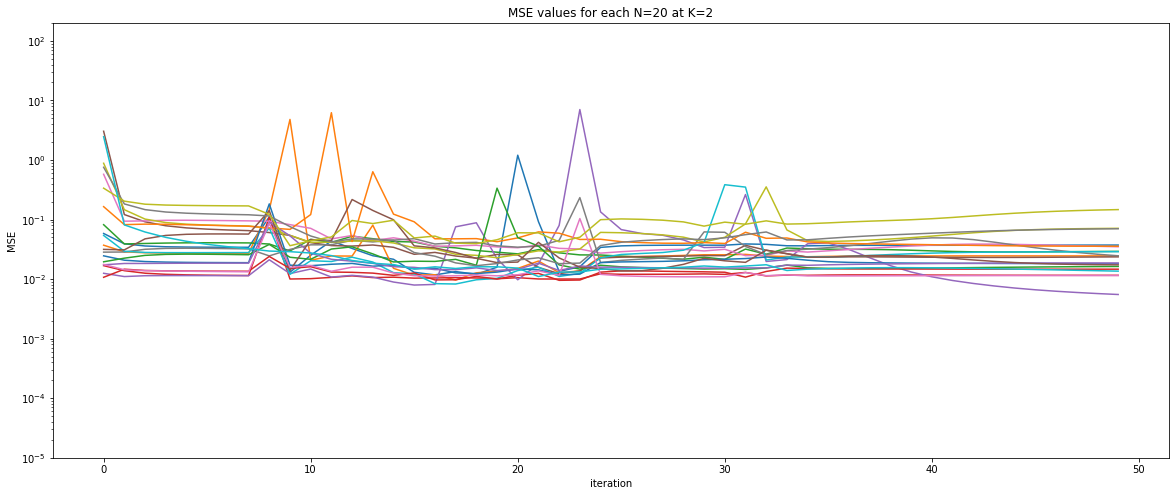

In [8]:
def kernelSim(iteration, D, K, Y, T):
    
    opening = "AC matrix of expirament of D=" + str(D) + " and K=" + str(K)

    alpha = 0
    Norm = 0
    N = len(Y)
    n = T[0].shape[0]
    kernel = Kernel(5.73)
    sigma = 1/np.sqrt(2*kernel.sigma)
    W = (1/sigma) * np.random.normal(size=(n,D))
    b = np.random.uniform(0,2*np.pi,(D,1))
    h = []
    m_i = []
    U = []

    # building the dictonary based on trainX dataset
    for i in range(N):
        h.append(np.sqrt(2/D) * np.cos(W.T @ T[i] + b))    
        m_i.append(Y[i].shape[1])
        if T[i].shape[1] == Y[i].shape[1]:
            U.append(T[i] @ Y[i].T)
    T = h
    
    # creates random matrix of size D * k
    #A = np.random.rand(D,K)
    A = np.ones((D,K)) / (D*K)
    
    # creates random matric of size K * D
    #C = np.random.rand(K,N)
    C = np.ones((K,N)) / (K*N)

    rmse = np.zeros((iteration,N))
    for epoch in tqdm(range(iteration)): 
        XX = np.zeros((D*K,D*K))
        B = np.zeros((D*K,1))
        X = [np.zeros((m_i[i],D*K)) for i in range(N)]
        for i in range(N):
            for j in range(m_i[i]):
                r = []
                for v in range(D):
                    r = np.hstack((r,T[i][v,j]* C.T[i]))
                X[i][j] = r
            XX += X[i].T @ X[i] + 2 * np.eye(D*K)
            B += X[i].T @ Y[i].T
        a = np.linalg.pinv(XX) @ B
        a = a.T[0]
        # A = np.zeros((D,K))

        for v in range(D):
            A[v] = a[v*K:(v+1)*K]

        AV = []
        AU = []
        for i in range(N):
#         AU.append(A.T @ T[i] @ Y[i].T + ((A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1))).T@C.T[i].reshape((K,1))))
#         AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)) + (A.T @ T[i] @ Y[i].T).T @ C.T[i].reshape((K,1)))        
           AU.append(A.T @ T[i] @ Y[i].T)
           AV.append(A.T @ T[i] @ T[i].T @ A @ C.T[i].reshape((K,1)))

        C = C * np.divide(AU,AV)[:,:,0].T        
        
        for i in range(N):
            AC = A @ C
            rmse[epoch][i] = np.mean((h[i].T @ AC.T[i]  - trainY[i])**2)
        
        np.savetxt("test.csv", AC, delimiter=",")
        #AC.tofile(fil)
        
    return rmse

Ki = 2
Di = 200

testing = kernelSim(50, Di, Ki, trainY, trainX)
plt.figure(figsize=(2*10, 6))

plt.figure(figsize=(20, 8))
for i in range(N):
    plt.semilogy(range(len(testing.T[i])),testing.T[i])
plt.title('MSE values for each N='+str(N)+' at K=' + str(Ki))
plt.ylabel("MSE")
plt.ylim([1e-5,2e2])
plt.xlabel("iteration")
plt.savefig(main_path + '/results/wcci/testing10.png',format='png',bbox_inches='tight')